# Case Studies Part 1

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
# import functions from modsim

from modsim import *

This chapter presents case studies where you can apply the tools we have learned so far to problems involving population growth, queueing systems, and tree growth.

This chapter is available as a Jupyter notebook where you can read the text, run the code, and work on the exercises.
Click here to access the notebooks: <https://allendowney.github.io/ModSimPy/>.

## Historical World Population

The Wikipedia page about world population growth includes estimates for world population from 12,000 years ago to the present (see <https://en.wikipedia.org/wiki/World_population_estimates.html>).

The following cells download an archived version of this page and read the data into a Pandas `DataFrame`.

In [3]:
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/data/World_population_estimates.html')

Downloaded World_population_estimates.html


In [4]:
from pandas import read_html

filename = 'World_population_estimates.html'
tables = read_html(filename, header=0, index_col=0, decimal='M')
len(tables)

6

In [5]:
table1 = tables[1]
table1.head()

,Population Reference Bureau (1973–2016)[15],United Nations Department of Economic and Social Affairs (2015)[16],Maddison (2008)[17],HYDE (2010)[citation needed],Tanton (1994)[18],Biraben (1980)[19],McEvedy & Jones (1978)[20],Thomlinson (1975)[21],Durand (1974)[22],Clark (1967)[23]
Year,,,,,,,,,,
-10000,NaN,NaN,NaN,2M[24],NaN,NaN,4.0,1–10M,NaN,NaN
-9000,NaN,NaN,NaN,4.,NaN,NaN,NaN,NaN,NaN,NaN
-8000,5.,NaN,NaN,5.,NaN,NaN,NaN,NaN,5–10M,NaN
-7000,NaN,NaN,NaN,8.,NaN,NaN,NaN,NaN,NaN,NaN
-6000,NaN,NaN,NaN,11.,NaN,NaN,NaN,NaN,NaN,NaN


Some of the values are null because not all researchers provide estimates for the same dates.

Again, we'll replace the long column names with more convenient abbreviations.

In [6]:
table1.columns = ['PRB', 'UN', 'Maddison', 'HYDE', 'Tanton',
                  'Biraben', 'McEvedy & Jones', 'Thomlinson', 'Durand', 'Clark']

Some of the estimates are in a form Pandas doesn't recognize as numbers, but we can coerce them to be numeric.

In [7]:
for col in table1.columns:
    table1[col] = pd.to_numeric(table1[col], errors='coerce')

Here are the results.  Notice that we are working in millions now, not billions.

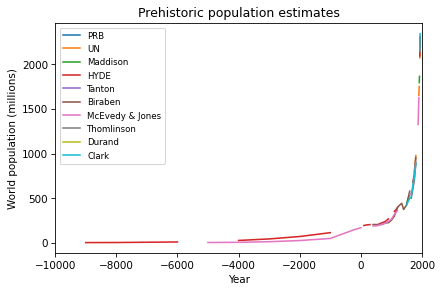

In [8]:
table1.plot()
decorate(xlim=[-10000, 2000], xlabel='Year',
         ylabel='World population (millions)',
         title='Prehistoric population estimates')
plt.legend(fontsize='small');

We can use `xlim` to zoom in on everything after Year 0.

The following figure shows the estimates of several research groups from 1 CE to the near present.

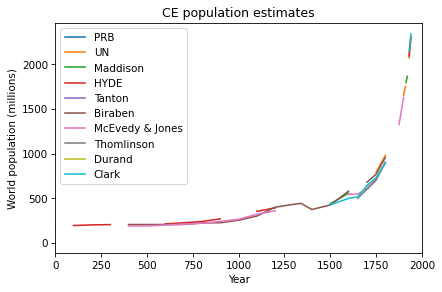

In [9]:
table1.plot()
decorate(xlim=[0, 2000], xlabel='Year',
         ylabel='World population (millions)',
         title='CE population estimates')

See if you can find a model that fits these estimates.
How well does your best model predict actual population growth from 1940 to the present?

In [10]:
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison',
                  'hyde', 'tanton', 'biraben', 'mj',
                  'thomlinson', 'durand', 'clark']

In [11]:
un = table2.un / 1e9
census = table2.census / 1e9

In [12]:
# Solution goes here
# I am going to use an exponential approach for the model, starting with setting the parameters
initial_population = table2['un'].iloc[0] / 1e9  # in billions
t_0 = table2.index.min()
t_end = table2.index.max()

system = System(t_0=t_0, t_end=t_end, P0=initial_population)

# defining the model as a function
def exp_growth(system, r):
    """Exponential growth model.

    system: System object
    r: growth rate
    """
    # array of years
    times = np.arange(system.t_0, system.t_end + 1)
    # the population for each year
    results = system.P0 * np.exp(r * (times - system.t_0))

    return times, results

In [13]:
# Solution goes here
# estimating growth rate (as part of the exponential model)
import matplotlib.pyplot as plt
growth_rates = np.linspace(0.01, 0.03, 100)  # Adjust range and step based on observations
best_fit_rate = None
smallest_error = float('inf')

# looping through each growth rate to find best fit
for r in growth_rates:
    _, model_population = exp_growth(system, r)
    # Calculate the error (e.g., mean squared error)
    error = np.mean((model_population - table2['un'] / 1e9)**2)
    if error < smallest_error:
        smallest_error = error
        best_fit_rate = r

print(f"Best fit growth rate: {best_fit_rate}")

Best fit growth rate: 0.017272727272727273


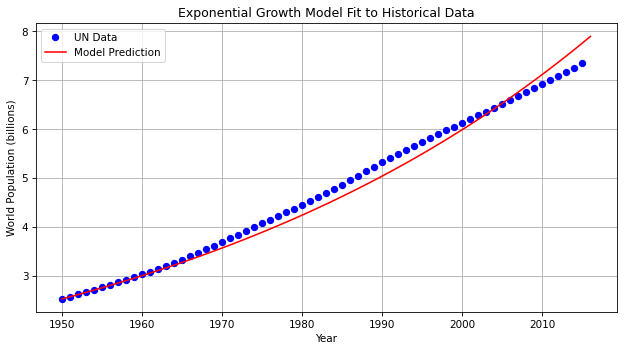

In [14]:
# plotting model against actual data
times, fitted_population = exp_growth(system, best_fit_rate)
plt.figure(figsize=(10, 5))
plt.plot(table2.index, table2['un'] / 1e9, 'bo', label='UN Data')
plt.plot(times, fitted_population, 'r-', label='Model Prediction')
plt.title('Exponential Growth Model Fit to Historical Data')
plt.xlabel('Year')
plt.ylabel('World Population (billions)')
plt.legend()
plt.grid(True)
plt.show()

## One Queue Or Two?

This case study is related to *queueing theory*, which is the study of systems that involve waiting in lines, also known as "queues".

Suppose you are designing the checkout area for a new store. There is
enough room in the store for two checkout counters and a waiting area
for customers. You can make two lines, one for each counter, or one line that feeds both counters.

In theory, you might expect a single line to be better, but it has some practical drawbacks: in order to maintain a single line, you might have to install barriers, and customers might be put off by what seems to be a longer line, even if it moves faster.

So you'd like to check whether the single line is really better and by
how much. Simulation can help answer this question.

This figure shows the three scenarios we'll consider:

![One queue, one server (left), one queue, two servers (middle), two
queues, two servers (right).](https://github.com/AllenDowney/ModSim/raw/main/figs/queue.png)

*One queue, one server (left), one queue, two servers (middle), two
queues, two servers (right).*

As we did in the bike share model, we'll divide time into discrete time steps of one minute.
And we'll assume that a customer is equally likely to arrive during any time step.
I'll denote this probability using the Greek letter lambda, $\lambda$, or the variable name `lam`. The value of $\lambda$ probably varies from day to day, so we'll have to consider a range of possibilities.

Based on data from other stores, you know that it takes 5 minutes for a customer to check out, on average. But checkout times are variable: most customers take less than 5 minutes, but some take substantially more. A simple way to model this variability is to assume that when a customer is checking out, they always have the same probability of finishing during the next time step, regardless of how long they have been checking out. I'll denote this probability using the Greek letter mu, $\mu$, or the variable name `mu`.

If we choose $\mu=1/5$ per minute, the average time for each checkout
will be 5 minutes, which is consistent with the data. Most people take less than 5 minutes, but a few take substantially longer, which is probably not a bad model of the distribution in real stores.

Now we're ready to implement the model. In the repository for this book, you'll find a notebook called *queue.ipynb* that contains some code to get you started and instructions.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/queue.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/queue.ipynb>.

As always, you should practice incremental development: write no more
than one or two lines of code at a time, and test as you go!

In [22]:
# assuming the arrivals follow a Poisson distribution but simulated in a discrete  manner (checking arrival at each time step), we can do the following:
import numpy as np

def update_two_queues(state, t, system):
    """ function for two separate queues, each with one server."""
    lam, mu = system.lam, system.mu
    queue1, queue2, wait_times1, wait_times2 = state.queue1, state.queue2, state.wait_times1, state.wait_times2

    # arrivals
    if np.random.random() < lam/2:  # assuming arrivals are split evenly between two queues
        queue1.append(0)
    if np.random.random() < lam/2:
        queue2.append(0)

    # queue 1
    if state.server1 > 0:
        state.server1 -= 1
    elif queue1:
        wait_times1.append(queue1.pop(0))
        state.server1 = np.random.exponential(1 / mu)

    # queue 2
    if state.server2 > 0:
        state.server2 -= 1
    elif queue2:
        wait_times2.append(queue2.pop(0))
        state.server2 = np.random.exponential(1 / mu)

    # waiting time in queues
    queue1 = [time + 1 for time in queue1]
    queue2 = [time + 1 for time in queue2]

    return System(queue1=queue1, queue2=queue2, wait_times1=wait_times1, wait_times2=wait_times2, server1=state.server1, server2=state.server2)

In [24]:
def run_two_queue_simulation(lam, mu, num_minutes):
    """Runs the simulation for two separate queues each with one server."""
    system = System(lam=lam, mu=mu, server1=0, server2=0)
    state = System(queue1=[], queue2=[], wait_times1=[], wait_times2=[], server1=0, server2=0)
    for _ in range(num_minutes):
        state = update_two_queues(state, 0, system)
    return state.wait_times1 + state.wait_times2

def run_one_queue_one_server_simulation(lam, mu, num_minutes):
    system = System(lam=lam, mu=mu, server1=0)
    state = System(queue=[], wait_times=[], server1=0)
    for _ in range(num_minutes):
        state = update_one_queue_one_server(state, 0, system)
    return state.wait_times

def run_one_queue_two_servers_simulation(lam, mu, num_minutes):
    system = System(lam=lam, mu=mu, server1=0, server2=0)
    state = System(queue=[], wait_times=[], server1=0, server2=0)
    for _ in range(num_minutes):
        state = update_one_queue_two_servers(state, 0, system)
    return state.wait_times

def update_one_queue_one_server(state, t, system):
    if np.random.random() < system.lam:
        state.queue.append(0)
    if state.server1 > 0:
        state.server1 -= 1
    elif state.queue:
        state.wait_times.append(state.queue.pop(0))
        state.server1 = np.random.exponential(1 / system.mu)
    state.queue = [time + 1 for time in state.queue]
    return state

def update_one_queue_two_servers(state, t, system):
    if np.random.random() < system.lam:
        state.queue.append(0)
    for i in range(1, 3):  # For two servers
        if getattr(state, f'server{i}') > 0:
            setattr(state, f'server{i}', getattr(state, f'server{i}') - 1)
        elif state.queue:
            state.wait_times.append(state.queue.pop(0))
            setattr(state, f'server{i}', np.random.exponential(1 / system.mu))
    state.queue = [time + 1 for time in state.queue]
    return state

# Parameters
lam = 1/5  # Arrival rate (customers per minute)
mu = 1/5   # Service rate (1/average service time)
num_minutes = 1000  # Simulation duration in minutes

# one queue with one server
wait_times_1 = run_one_queue_one_server_simulation(lam, mu, num_minutes)
print(f"Average wait time for 1 queue, 1 server: {np.mean(wait_times_1):.2f} minutes")

# one queue with two servers
wait_times_2 = run_one_queue_two_servers_simulation(lam, mu, num_minutes)
print(f"Average wait time for 1 queue, 2 servers: {np.mean(wait_times_2):.2f} minutes")

# two queues with one server each
wait_times_3 = run_two_queue_simulation(lam, mu, num_minutes)
print(f"Average wait time for 2 queues, 2 servers: {np.mean(wait_times_3):.2f} minutes")


Average wait time for 1 queue, 1 server: 117.71 minutes
Average wait time for 1 queue, 2 servers: 2.36 minutes
Average wait time for 2 queues, 2 servers: 7.63 minutes


## Predicting Salmon Populations

Each year the U.S. Atlantic Salmon Assessment Committee reports
estimates of salmon populations in oceans and rivers in the northeastern United States. The reports are useful for monitoring changes in these populations, but they generally do not include predictions.

The goal of this case study is to model year-to-year changes in
population, evaluate how predictable these changes are, and estimate the probability that a particular population will increase or decrease in the next 10 years.

As an example, I use data from the 2017 report, which provides population estimates for the Narraguagus and Sheepscot Rivers
in Maine.

In the repository for this book, you'll find a notebook called
*salmon.ipynb* that contains this data and some code to get you started.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/salmon.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/salmon.ipynb>.

You should take my instructions as suggestions; if you want to try
something different, please do!



In [ ]:
# solved in a separate jupyter notebook named salmon.ipynb

## Tree Growth

This case study is based on "Height-Age Curves for Planted Stands of
Douglas Fir, with Adjustments for Density", a working paper by
Flewelling et al.
It provides *site index curves*, which are curves that show the
expected height of the tallest tree in a stand of Douglas fir as a
function of age, for a stand where the trees are the same age.
Depending on the quality of the site, the trees might grow more quickly or slowly. So each curve is identified by a *site index* that indicates the quality of the site.

The goal of this case study is to explain the shape of these
curves, that is, why trees grow the way they do.
The answer I propose involves fractal dimensions, so you might find it interesting.

In the repository for this book, you'll find a notebook called
*trees.ipynb* that incrementally develops a model of tree growth and uses it to fit the data.
You can download it from <https://github.com/AllenDowney/ModSimPy/raw/master/examples/trees.ipynb> or run it on Colab at <https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/trees.ipynb>.

There are no exercises in this case study, but it is an example of what you can do with the tools we have so far and a preview of what you will be able to do with the tools in the next few chapters.

In [ ]:
# solved in a separate jupyter notebook named trees.ipynb